In [1]:
import pandas, keras
import numpy as np
from sklearn.metrics import roc_auc_score
from IPython.display import FileLink, FileLinks

Using TensorFlow backend.


In [2]:
# 1 image has 16x16 pixels = 256 pixels
pixels = ["pixel_{0}".format(i) for i in range(36)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,6,6), axis=-1)


#store_train = pandas.HDFStore("SNG_p10_pixelTrain.h5")
store_train = pandas.HDFStore("pixelTrain.h5")
#store_train = pandas.HDFStore("pixelTrain.h5")

df_train = store_train.select("df",stop=-1)
df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]
#images_train = to_image(df_train)

store_test = pandas.HDFStore("pixelTrain30k.h5")

df_test = store_test.select("df",stop=-1)
df_test = df_test[(df_test["GenDeltaR"]<0.1) & (df_test["nUniqueSimTracksInSharedHit"]>-1)]#print(df_test)
images_test = to_image(df_test)

comb = pandas.concat([df_train,df_test])

df_train=comb.sample(frac=0.6)
df_test=comb.drop(df_train.index)

df_train = df_train[(df_train["GenDeltaR"]<0.1) & (df_train["nUniqueSimTracksInSharedHit"]>-1)]
images_train = to_image(df_train)
images_test = to_image(df_test)

#print(df_train.iloc[[28946]])
#print(df_train)
#print df_train
#print sum(df_train["isSharedHit"])

In [3]:
print df_test.shape
print df_train.shape

(157, 42)
(237, 42)


In [45]:
from keras.layers import Dense, Dropout, Activation
# Define the network
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=(4,4), padding='same', activation='relu'))
#model.add(keras.layers.Conv2D(16, kernel_size=(4,4), padding='same', activation='relu'))
#model.add(keras.layers.Conv2D(16, kernel_size=(2,2), padding='same', activation='relu'))
#model.add(keras.layers.Conv2D(16, kernel_size=(1,1), padding='same', activation='relu'))
# max pooling 2D
#model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same', data_format="channels_last"))
model.add(keras.layers.Flatten(input_shape=(6,6,1),data_format = "channels_last"))
#model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
# dropout 10%
model.add(Dropout(0.1))
model.add(keras.layers.Dense(2, activation='softmax'))
#print(model.summary())
                                                    
# Train the network
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics = ["accuracy"])
model.fit(images_train, keras.utils.to_categorical(df_train["nUniqueSimTracksInSharedHit"]>1), epochs=30, validation_split=0.1) # validation fraction
print(model.summary)

Train on 213 samples, validate on 24 samples
Epoch 1/30
213/213 [==============================] - 0s 2ms/step - loss: 0.6865 - acc: 0.5775 - val_loss: 0.6959 - val_acc: 0.4167
Epoch 2/30
213/213 [==============================] - 0s 148us/step - loss: 0.6547 - acc: 0.6197 - val_loss: 0.6793 - val_acc: 0.4167
Epoch 3/30
213/213 [==============================] - 0s 129us/step - loss: 0.6226 - acc: 0.6103 - val_loss: 0.6819 - val_acc: 0.4583
Epoch 4/30
213/213 [==============================] - 0s 132us/step - loss: 0.5815 - acc: 0.6479 - val_loss: 0.6022 - val_acc: 0.5833
Epoch 5/30
213/213 [==============================] - 0s 125us/step - loss: 0.5534 - acc: 0.7559 - val_loss: 0.5296 - val_acc: 0.7083
Epoch 6/30
213/213 [==============================] - 0s 122us/step - loss: 0.5189 - acc: 0.7700 - val_loss: 0.5388 - val_acc: 0.7083
Epoch 7/30
213/213 [==============================] - 0s 123us/step - loss: 0.4931 - acc: 0.7887 - val_loss: 0.4351 - val_acc: 0.7917
Epoch 8/30
213/213 

/cvmfs/sft.cern.ch/lcg/views/LCG_95a/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211840). Check your callbacks.
  % delta_t_median)
/cvmfs/sft.cern.ch/lcg/views/LCG_95a/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106861). Check your callbacks.
  % delta_t_median)


Epoch 24/30
213/213 [==============================] - 0s 112us/step - loss: 0.3329 - acc: 0.8498 - val_loss: 0.2655 - val_acc: 1.0000
Epoch 25/30
213/213 [==============================] - 0s 109us/step - loss: 0.3203 - acc: 0.8498 - val_loss: 0.2456 - val_acc: 1.0000
Epoch 26/30
213/213 [==============================] - 0s 118us/step - loss: 0.3153 - acc: 0.8357 - val_loss: 0.2588 - val_acc: 1.0000
Epoch 27/30
213/213 [==============================] - 0s 110us/step - loss: 0.3109 - acc: 0.8592 - val_loss: 0.2479 - val_acc: 0.9583
Epoch 28/30
213/213 [==============================] - 0s 111us/step - loss: 0.2994 - acc: 0.8685 - val_loss: 0.2416 - val_acc: 0.9583
Epoch 29/30
213/213 [==============================] - 0s 106us/step - loss: 0.2976 - acc: 0.8732 - val_loss: 0.2490 - val_acc: 0.9583
Epoch 30/30
213/213 [==============================] - 0s 105us/step - loss: 0.2954 - acc: 0.8779 - val_loss: 0.2173 - val_acc: 0.9583
<bound method Sequential.summary of <keras.engine.seque

In [46]:
#store_test = pandas.HDFStore("pixelTrain30k.h5")

#df_test = store_test.select("df",stop=-1)
##pixels
#df_test[pixels]

In [47]:
### Evaluate performance on independent sample
# DO NOT CHANGE BELOW!

# Prepare input
#store_test = pandas.HDFStore("SNG_p10_pixelTrain.h5")


#store_test = pandas.HDFStore("pixelTest_v3.h5")
#store_test = pandas.HDFStore("pixelTrain30k.h5")

#df_test = store_test.select("df",stop=-1)
#df_test = df_test[(df_test["GenDeltaR"]<0.1) & (df_test["nUniqueSimTracksInSharedHit"]>-1)]#print(df_test)
#images_test = to_image(df_test)
#images_test = pandas.read_hdf("pixelTrain.h5")
#images_test = images_train
#df_test = df_train

# Run DNN
print("Running on full test sample. This may take a moment.")
ret = model.predict(images_test)
np.save("result.npy",ret[:,1])
print(ret)
#print ret
#print df_test["isSharedHit"]
#keras.utils.to_categorical(df_test["isSharedHit"])
#print len(keras.utils.to_categorical(df_test["isSharedHit"]))
#print keras.utils.to_categorical(df_train["isSharedHit"],dtype='int32').sum()
#print len(keras.utils.to_categorical(df_train["isSharedHit"])),keras.utils.to_categorical(df_train["isSharedHit"]).sum()

Running on full test sample. This may take a moment.
[[0.00803677 0.99196315]
 [0.31486294 0.68513703]
 [0.06175141 0.93824863]
 [0.8146907  0.18530925]
 [0.9329133  0.06708672]
 [0.06276684 0.93723315]
 [0.94402903 0.05597094]
 [0.03544045 0.9645596 ]
 [0.03980541 0.96019465]
 [0.7068269  0.2931731 ]
 [0.75686353 0.24313642]
 [0.04001368 0.9599863 ]
 [0.01295954 0.98704046]
 [0.2226918  0.77730817]
 [0.4190356  0.5809644 ]
 [0.4980062  0.50199383]
 [0.74687964 0.2531203 ]
 [0.04399741 0.9560026 ]
 [0.12046839 0.87953156]
 [0.01030015 0.98969984]
 [0.03192724 0.9680728 ]
 [0.02115642 0.97884357]
 [0.37641546 0.62358457]
 [0.13081722 0.86918277]
 [0.00996606 0.9900339 ]
 [0.87646884 0.12353117]
 [0.06054148 0.9394585 ]
 [0.34924766 0.6507523 ]
 [0.15673725 0.8432628 ]
 [0.8471933  0.15280677]
 [0.60811317 0.39188683]
 [0.00432076 0.9956793 ]
 [0.00271595 0.99728405]
 [0.02674106 0.9732589 ]
 [0.87061363 0.12938641]
 [0.04865483 0.9513452 ]
 [0.84526426 0.1547357 ]
 [0.7902758  0.2097241

In [48]:
from sklearn.metrics import roc_curve
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical(df_test["isSharedHit"])[:,1], ret[:,1])
fpr_keras, tpr_keras, thresholds_keras = roc_curve(keras.utils.to_categorical(df_test["nUniqueSimTracksInSharedHit"]>1)[:,1], ret[:,1])

print fpr_keras,tpr_keras
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print auc_keras
print np.isnan(fpr_keras).all()
print len(fpr_keras),len(tpr_keras)
np.save("fpr_keras.npy",fpr_keras)
np.save("tpr_keras.npy",tpr_keras)

[0.       0.       0.       0.       0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.03125  0.03125
 0.03125  0.03125  0.03125  0.03125  0.046875 0.046875 0.0625   0.0625
 0.09375  0.09375  0.109375 0.109375 0.125    0.125    0.15625  0.15625
 0.171875 0.171875 0.21875  0.21875  0.3125   0.34375  0.359375 0.359375
 0.375    0.375    0.546875 0.546875 0.59375  0.625    0.640625 0.6875
 0.703125 0.703125 0.78125  0.8125   0.84375  0.890625 1.      ] [0.0106383  0.05319149 0.07446809 0.09574468 0.09574468 0.10638298
 0.17021277 0.20212766 0.24468085 0.28723404 0.30851064 0.4787234
 0.5        0.59574468 0.59574468 0.60638298 0.63829787 0.65957447
 0.68085106 0.74468085 0.74468085 0.76595745 0.76595745 0.79787234
 0.79787234 0.81914894 0.81914894 0.85106383 0.85106383 0.87234043
 0.87234043 0.88297872 0.88297872 0.90425532 0.90425532 0.92553191
 0.92553191 0.92553191 0.92553191 0.93617021 0.93617021 0.94680851
 0.94680851 0.95744681 0.95744681 0

0.9241190159574468


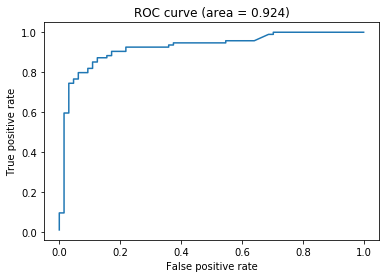

In [49]:
import numpy as np
fpr_keras = np.load("fpr_keras.npy")
tpr_keras = np.load("tpr_keras.npy")
#print fpr_keras[2300]
auc = np.trapz(tpr_keras,fpr_keras)
print auc
#auc_keras = 0.623416233325797
#auc_keras = 0.665570454761781
#print test
import matplotlib.pyplot as plt
plt.figure(1)
#plt.figure(figsize=(200, 200))
#plt.plot([0, 1], [0, 1], label='test')
#plt.plot([1,2,3],[5,6,7], label = 'test')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc))
#plt.plot(fpr_keras, tpr_keras, label='test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (area = {:.3f})'.format(auc))
#plt.legend(loc='best')
plt.savefig("ROC.png")
plt.savefig("ROC.pdf")

plt.show()


In [102]:
#sanity check: no overlap between train and test
pandas.merge(df_train, df_test, on=[x for x in df_train.columns], how='inner')

,isSharedHit,trackPt,trackEta,trackPhi,nUniqueSimTracksInSharedHit,GenDeltaR,pixel_0,pixel_1,pixel_2,pixel_3,...,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35


In [115]:
df_train.shape

(8432, 42)

In [116]:
df_test.shape

(2344, 42)

In [123]:
#df_test[(df_test["nUniqueSimTracksInSharedHit"]>-1) & (df_test["GenDeltaR"]<0.1)]

,isSharedHit,trackPt,trackEta,trackPhi,nUniqueSimTracksInSharedHit,GenDeltaR,pixel_0,pixel_1,pixel_2,pixel_3,...,pixel_26,pixel_27,pixel_28,pixel_29,pixel_30,pixel_31,pixel_32,pixel_33,pixel_34,pixel_35
25,1,1.929511,-2.201498,1.929511,1,0.014203,0.0,0.000000,0.000000,0.151873,...,0.074612,0.040008,0.000000,0.0,0.0,0.0,0.107974,0.000000,0.000000,0.0
30,1,5.074821,-1.558144,5.074821,2,0.005103,0.0,0.084432,0.000000,0.000000,...,0.040934,0.000000,0.151445,0.0,0.0,0.0,0.000000,0.000000,0.245498,0.0
37,0,27.976690,-0.267991,27.976690,1,0.093300,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
39,1,1.326517,-2.043829,1.326517,2,0.042632,0.0,0.000000,0.054752,0.054825,...,0.059799,0.166494,0.000000,0.0,0.0,0.0,0.071077,0.068511,0.000000,0.0
69,1,1.330709,-2.043563,1.330709,2,0.043240,0.0,0.000000,0.087983,0.091203,...,0.083277,0.139740,0.000000,0.0,0.0,0.0,0.045860,0.090908,0.000000,0.0
92,1,1.927646,-2.203123,1.927646,1,0.016287,0.0,0.000000,0.000000,0.000000,...,0.000000,0.403630,0.056244,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
119,1,4.657765,-1.873906,4.657765,2,0.005257,0.0,0.000000,0.000000,0.000000,...,0.254677,0.101919,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
140,1,4.689703,-2.010829,4.689703,1,0.032041,0.0,0.000000,0.000000,0.163354,...,0.000000,0.193271,0.000000,0.0,0.0,0.0,0.000000,0.182736,0.000000,0.0
228,1,13.573482,-0.220184,13.573482,1,0.003009,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
229,1,1.924295,-2.205955,1.924295,1,0.020649,0.0,0.000000,0.000000,0.000000,...,0.072539,0.114365,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


shared hits with at least 2 sim tracks:
0.569620253165


Text(0.5,1,'nUniqueSimTracksInSharedHit')

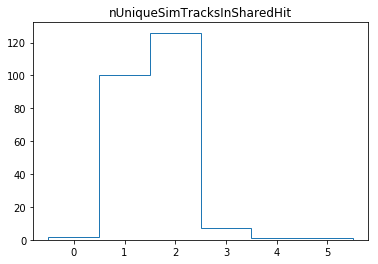

In [34]:
print "shared hits with at least 2 sim tracks:"
print float(sum(df_train["nUniqueSimTracksInSharedHit"]>1))/len(df_train["nUniqueSimTracksInSharedHit"])
plt.hist(df_train["nUniqueSimTracksInSharedHit"],histtype="step",bins=6,range=(-0.5,5.5))
plt.title("nUniqueSimTracksInSharedHit")

In [34]:
sum(df_train["nUniqueSimTracksInSharedHit"]>-1)

313

In [33]:
82.0/30000

0.0027333333333333333

In [5]:
import matplotlib.pyplot as plt

0.582278481013


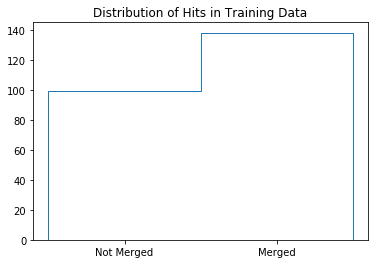

In [6]:
print float(sum(df_train["nUniqueSimTracksInSharedHit"]>1))/len(df_train["nUniqueSimTracksInSharedHit"])
plt.hist(df_train["nUniqueSimTracksInSharedHit"]>1,histtype="step",bins=2,range=(-0.5,1.5))
plt.title("Distribution of Hits in Training Data")
plt.xticks([0,1],("Not Merged","Merged"))
plt.savefig("merged_dist.png")
plt.savefig("merged_dist.pdf")